In [11]:
import pandas as pd
import requests
import urllib3

import sys
import urllib3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.options.mode.chained_assignment = None
from datetime import datetime, timedelta
import re
import math
import webbrowser
import matplotlib as mpl
from timezonefinder import TimezoneFinder
import pytz


# import datetime
from suntime import Sun

tab10 = plt.get_cmap('tab10')

In [12]:
### Run This


aspect_dict = {'N':0,
     'NNE':22.5,
     'NE':45,
     'ENE':67.5,
     'E':90,
     'ESE':112.5,
     'SE':135,
     'SSE':157.5,
     'S':180,
     'SSW':202.5,
     'SW':225,
     'WSW':247.5,
     'W':270,
     'WNW':292.5,
     'NW':315,
     'NNW':337.5}

def human_aspect(deg):
    for aspect,aspect_deg in aspect_dict.items():
        if abs(deg-aspect_deg) < 22.5:
            final_aspect = aspect
            return final_aspect

def parse_time_period(time_string):
    time_list = time_string.split('/')
    start_time = pd.to_datetime(time_list[0]) - pd.Timedelta(time_list[1])
    end_time = pd.to_datetime(time_list[0])
    return start_time,end_time

def parse_time_period2(time_string):
    time_list = time_string.split('/')
    end_time = pd.to_datetime(time_list[0]) + pd.Timedelta(time_list[1])
    start_time = pd.to_datetime(time_list[0])
    return start_time,end_time

def get_snotel_df(SiteName, years = 'recent'):
    SiteID = site_df.loc[SiteName]['snotel_sitenumber']
    snotel_site_name = site_df.loc[SiteName]['snotel_sitename']
    StateAbb = site_df.loc[SiteName]['state']
    ############## Snotel
    today_string = datetime.today().date().strftime('%Y-%m-%d')
    threedaysago_string = (datetime.today() - timedelta(days = 8)).date().strftime('%Y-%m-%d')
    if years == 'recent':
        StartDate = threedaysago_string
        EndDate = today_string
    else:
        yearsago_string = (datetime.today() - timedelta(days = years*365)).date().strftime('%Y-%m-%d')
        StartDate = yearsago_string
        EndDate = today_string
        

    # Example URL for Hourly snow report for bear lake
    #     https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/322:CO:SNTL%257Cid=%2522%2522%257Cname/2025-01-07,2025-01-09/SNWD::value,WTEQ::value,TAVG::value,WDIRV::value,WSPDV::value?fitToScreen=false
    #     Basically all the column options:
    #     https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/322:CO:SNTL%257Cid=%2522%2522%257Cname/2025-02-14,2025-02-18/
    column_list = ['WTEQ','SNWD','PREC','TOBS','WDIRV','WSPDV','WSPDX']
    url1 = 'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/'
    url2 = f'{SiteID}:{StateAbb}:SNTL%257Cid=%2522%2522%257Cname/'
    url3 = f'{StartDate},{EndDate}/'
    column_list = ['WTEQ','SNWD','PREC','TOBS','WDIRV','WSPDV','WSPDX']
    url4 = ','.join([col + '::value' for col in column_list])
    url5 = '?fitToScreen=false'
    url = url1+url2+url3+url4+url5
    print('Snotel URL:',url)
    human_snotel_url = f'https://wcc.sc.egov.usda.gov/nwcc/site?sitenum={SiteID}'
    print(f'  (for humans): {human_snotel_url}')

    print(f'Start retrieving SNOTEL data for {snotel_site_name}, {SiteID}')

    http = urllib3.PoolManager()
    response = http.request('GET', url)
    data = response.data.decode('utf-8')
    print('     Received SNOTEL data')

    i=0
    for line in data.split("\n"):
        if line.startswith("#"):
            i=i+1
    data = data.split("\n")[i:]

    snotel_df = pd.DataFrame.from_dict(data)
    print('     Made dataframe')

    snotel_df = snotel_df[0].str.split(',', expand=True)
    
    snotel_df.rename(columns={0:snotel_df[0][0], 
                        1:snotel_df[1][0], 
                        2:snotel_df[2][0],
                        3:snotel_df[3][0],
                        4:snotel_df[4][0],
                        5:snotel_df[5][0],
                        6:snotel_df[6][0],
                        7:snotel_df[7][0]}, inplace=True)

    snotel_df.rename(columns = {f'{snotel_site_name} ({SiteID}) Snow Depth (in)':'snow_depth_in',
                                f'{snotel_site_name} ({SiteID}) Snow Water Equivalent (in)':'swe_in',
                                f'{snotel_site_name} ({SiteID}) Air Temperature Average (degF)':'temperature_f',
                                f'{snotel_site_name} ({SiteID}) Wind Direction Average (degree)':'wind_dir',
                                f'{snotel_site_name} ({SiteID}) Wind Speed Average (mph)':'wind_speed',
                                f'{snotel_site_name} ({SiteID}) Precipitation Accumulation (in)':'precipitation_accumulation',
                                f'{snotel_site_name} ({SiteID}) Air Temperature Observed (degF)':'temperature_observed',
                                f'{snotel_site_name} ({SiteID}) Wind Speed Maximum (mph)':'wind_speed_max'}, inplace = True)
    snotel_df.drop(0, inplace=True)
    snotel_df.dropna(inplace=True)
    snotel_df.reset_index(inplace=True, drop=True)
    snotel_df["Date"] = pd.to_datetime(snotel_df["Date"])

    for col in snotel_df.columns:
        if col != 'Date':
            snotel_df[col] = pd.to_numeric(snotel_df[col])

    print('     Getting new snow totals')
    # snotel_df['snow_depth_in'] = snotel_df['snow_depth_in'].rolling(window=3).mean()
    snotel_df['new_snow'] = snotel_df['snow_depth_in'].diff()
    snotel_df['new_swe'] = snotel_df['swe_in'].diff()
    snotel_df['day'] = snotel_df['Date'].dt.dayofweek
    snotel_df['color'] = snotel_df['day'].apply(lambda x:tab10(x))

    
    print('     rolling average')
    # print(new_snow_24h)
    # snotel_df_24h.plot.bar(x = 'Date', y = 'snow_depth_in', ylim = (35,45))
    return snotel_df


def split_name_num(text):
    result = list(re.findall('(.+) \((\d+)\)',text)[0])
    return result





def get_nearest_snotel_site(name, lat, lon):
    # if name not in site_df.index:
    #     raise ValueError(f'Could not find {name} in sites.csv. Please add it to the file.')
    # lat = site_df.loc[name]['lat']
    # lon = site_df.loc[name]['lon']
    # print(name, lat, lon)


    snotel_sites_df['lat_dist'] = lat - snotel_sites_df['lat']
    snotel_sites_df['lon_dist'] = lon - snotel_sites_df['lon']
    def get_dist(row):
        return math.sqrt(row['lat_dist']**2 + row['lon_dist']**2)


    snotel_sites_df['dist'] = snotel_sites_df.apply(get_dist, axis=1)
    # display(snotel_sites_df[snotel_sites_df['dist'] == snotel_sites_df['dist'].min()])
    closest_snotel_site_df = snotel_sites_df[snotel_sites_df['dist'] == snotel_sites_df['dist'].min()]
    closest_snotel_site = closest_snotel_site_df.reset_index().loc[0]['name']
    sitenumber = closest_snotel_site_df.reset_index().loc[0]['number']
    state = closest_snotel_site_df.reset_index().loc[0]['state']
    # return closest_snotel_site
    return pd.Series({'snotel_sitename':closest_snotel_site,
                      'snotel_sitenumber':sitenumber,
                      'state':state})

snotel_sites_df = pd.read_csv('snotel_sites.csv') # From https://wcc.sc.egov.usda.gov/nwcc/yearcount?network=sntl&state=&counttype=statelist
snotel_sites_df[['name','number']] = snotel_sites_df['site_name'].apply(lambda x: pd.Series(split_name_num(x)))
snotel_sites_df.set_index('name', inplace= True)

site_df = pd.read_csv('sites.csv')
# site_df['snotel_sitename'] = site_df.apply(lambda x: get_nearest_snotel_site(x['name'],x['lat'],x['lon']), axis = 1)
site_df[['snotel_sitename','snotel_sitenumber','state']] = site_df.apply(lambda x: get_nearest_snotel_site(x['name'],x['lat'],x['lon']), axis = 1)
site_df.set_index('name', inplace = True)
if int(site_df.index.value_counts().max()) > 1:
    raise ValueError('Duplicate Entries in sites.csv file. All names must be unique')
display(site_df)


<>:130: SyntaxWarning: invalid escape sequence '\('
<>:130: SyntaxWarning: invalid escape sequence '\('
C:\Users\JonBanks\AppData\Local\Temp\ipykernel_16832\3482163843.py:130: SyntaxWarning: invalid escape sequence '\('
  result = list(re.findall('(.+) \((\d+)\)',text)[0])


,lat,lon,snotel_sitename,snotel_sitenumber,state
name,,,,,
Bear Lake,40.312300,-105.646500,Bear Lake,322,CO
Caribou,39.981360,-105.579430,Lake Eldora,564,CO
Heavenly,38.934799,-119.902521,Heavenly Valley,518,CA
Kirkwood,38.676423,-120.070006,Carson Pass,1067,CA
Loveland,39.672620,-105.905496,Loveland Basin,602,CO
Steamboat,40.452865,-106.772108,Dry Lake,457,CO
Alyeska,60.957334,-149.081164,Mt. Alyeska,1103,AK
Turnagain Pass,60.802227,-149.186981,Turnagain Pass,954,AK
Cameron Pass,40.546110,-105.901690,Joe Wright,551,CO


In [13]:
SiteName = 'Bear Lake'

NOAA API Info: https://www.weather.gov/documentation/services-web-api

Snotel URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/322:CO:SNTL%257Cid=%2522%2522%257Cname/2025-04-23,2025-05-01/WTEQ::value,SNWD::value,PREC::value,TOBS::value,WDIRV::value,WSPDV::value,WSPDX::value?fitToScreen=false
  (for humans): https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=322
Start retrieving SNOTEL data for Bear Lake, 322
     Received SNOTEL data
     Made dataframe
     Getting new snow totals
     rolling average
Checking NOAA forecast landing page
    https://api.weather.gov/points/40.3123,-105.6465
Retrieving NOAA Forecast for 40.3123, -105.6465
      https://api.weather.gov/gridpoints/BOU/42,89/forecast/hourly
      For Humans: https://forecast.weather.gov/MapClick.php?lat=40.3123&lon=-105.6465
Retrieving NOAA snowfall data
      https://api.weather.gov/gridpoints/BOU/42,89
     converting to json
     Received snowfall and skycover data
     Parsing snowfall data
     Parsing skycover data
  

c:\Users\JonBanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\labellines\core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=20209.333333333332, xmax=20215.791666666668, xval=0.5). Clipping it into the allowed range.
  warnings.warn(


CAIC: https://avalanche.state.co.us/?lat=40.3123&lng=-105.6465
High: 40 F
Low: 25 F
Wind: 8 mph WNW
Predicted Snowfall: 0.5 inches
New Snow: 4.0 inches


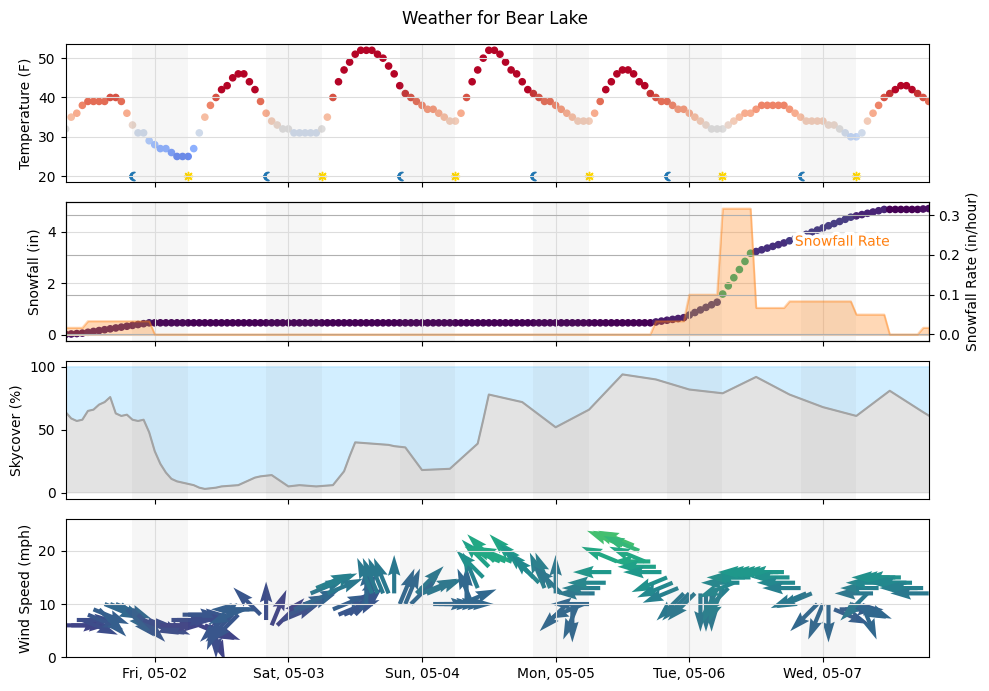

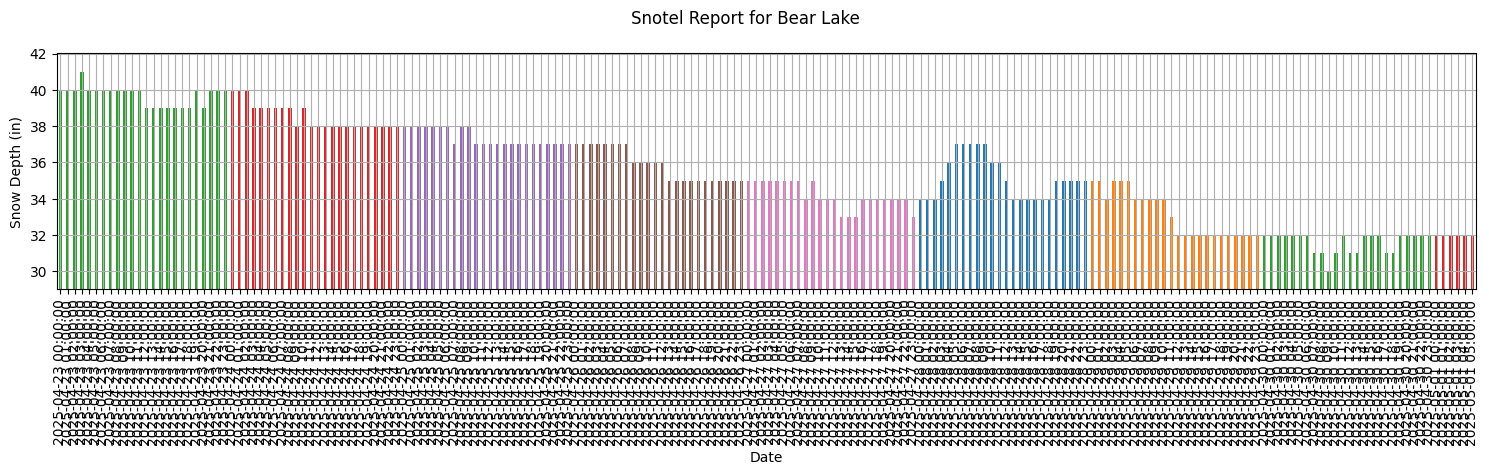

In [14]:
lat = site_df.loc[SiteName]['lat']
lon = site_df.loc[SiteName]['lon']

co_sites_df = snotel_sites_df[snotel_sites_df['state'] == 'CO']

snotel_df = get_snotel_df(SiteName)

def get_new_snow(snotel_df):
    yesterday_string = (datetime.today() - timedelta(days = 1)).date().strftime('%Y-%m-%d')
    snotel_df_24h = snotel_df[snotel_df['Date'] > yesterday_string]

    new_snow_24h = snotel_df_24h[snotel_df_24h['new_snow'] >= 0]['new_snow'].sum()
    return new_snow_24h

def get_new_snow_and_df(SiteName):
    snotel_df = get_snotel_df(SiteName)
    new_snow_24h = get_new_snow(snotel_df)
    return new_snow_24h

new_snow_24h = get_new_snow(snotel_df)


################ NOAA Forecast
forecast_url = f'https://api.weather.gov/points/{lat},{lon}'
print('Checking NOAA forecast landing page')
print(f'    {forecast_url}')
forecast_landing_data = requests.get(forecast_url)
# print(f'     converting to JSON')
forecast_landing_json = forecast_landing_data.json()
hourly_forecast_url = forecast_landing_json['properties']['forecastHourly']
print(f'Retrieving NOAA Forecast for {lat}, {lon}')
print(f'      {hourly_forecast_url}')
human_noaa_url = f'https://forecast.weather.gov/MapClick.php?lat={lat}&lon={lon}'
print(f'      For Humans: {human_noaa_url}')
hourly_forecast_data = requests.get(hourly_forecast_url)
# print(f'     converting to json')
hourly_forecast_json = hourly_forecast_data.json()
# print('     Received NOAA data')
hourly_forecast_df = pd.json_normalize(hourly_forecast_json['properties']['periods'])
# hourly_forecast_df['startTime'] = pd.to_datetime(hourly_forecast_df['startTime']) # This just quit working
hourly_forecast_df['startTime'] = pd.to_datetime(hourly_forecast_df['startTime'], utc = True)
hourly_forecast_df['startTime'] = hourly_forecast_df['startTime'].dt.tz_localize(None) # Remove time zone since snowfall data doesn't have a timezone
hourly_forecast_df['endTime'] = pd.to_datetime(hourly_forecast_df['endTime'])




grid_data_url = forecast_landing_json['properties']['forecastGridData']
print(f'Retrieving NOAA snowfall data')
print(f'      {grid_data_url}')
grid_data_data = requests.get(grid_data_url)
print('     converting to json')
grid_data_json = grid_data_data.json()
print('     Received snowfall and skycover data')
snowfall_df = pd.json_normalize(grid_data_json['properties']['snowfallAmount']['values'])
skycover_df = pd.json_normalize(grid_data_json['properties']['skyCover']['values'])

print('     Parsing snowfall data')
snowfall_df['startTime'] = snowfall_df['validTime'].apply(lambda x: parse_time_period2(x)[0])
snowfall_df['endTime'] = snowfall_df['validTime'].apply(lambda x: parse_time_period2(x)[1])

print('     Parsing skycover data')
skycover_df['startTime'] = skycover_df['validTime'].apply(lambda x: parse_time_period2(x)[0])
skycover_df['endTime'] = skycover_df['validTime'].apply(lambda x: parse_time_period2(x)[1])



# Getting hourly snowfall and merging with main df
print("     Generating hourly snowfal data")
hourly_snowfall_df = pd.DataFrame(columns = ['startTime','snowfall_mm'])
for line in snowfall_df.iterrows():
    snowfall = line[1]['value']
    start_time = line[1]['startTime']
    end_time = line[1]['endTime']
    duration_hours = (end_time-start_time).total_seconds()/(60*60)
    snowfall_per_hour = snowfall/duration_hours
    for i in range(int(duration_hours)):
        hourly_snowfall_df.loc[len(hourly_snowfall_df)] = [start_time + timedelta(hours = i), snowfall_per_hour]

hourly_snowfall_df['startTime'] = pd.to_datetime(hourly_snowfall_df['startTime'])
hourly_snowfall_df['startTime'] = hourly_snowfall_df['startTime'].dt.tz_localize(None) # Remove time zone since snowfall data doesn't have a timezone

noaa_df = hourly_snowfall_df.merge(hourly_forecast_df, on = 'startTime', how = 'inner')

noaa_df['snowfall_in'] = noaa_df['snowfall_mm'] / 25.4
noaa_df['total_snowfall_in'] = noaa_df['snowfall_in'].cumsum() # Sums all previous snowfall amounts to give total snowfall
noaa_df['windSpeed_mph'] = noaa_df['windSpeed'].apply(lambda x: float(x.split(' ')[0]))

print('Calculating Wind Direction')
dir_list = ['N','NNW','NW','WNW','W','WSW','SW','SSW','S','SSE','SE','ESE','E','ENE','NE','NNE']
direction_dict = {}

noaa_df = noaa_df[noaa_df['windDirection'].isin(dir_list)]
for i, dir in enumerate(dir_list):
    angle = 22.5*i
    scale = 0.1
    direction_dict[dir] = (scale*math.sin(angle*math.pi/180),-scale*math.cos(angle*math.pi/180))

noaa_df['wind_x'] = noaa_df['windDirection'].apply(lambda x: direction_dict[x][0])
noaa_df['wind_y'] = noaa_df['windDirection'].apply(lambda x: direction_dict[x][1])
noaa_df['total_hours'] = (noaa_df['startTime']-noaa_df['startTime'].min()).dt.total_seconds()/(60*60)

# Change timezones


tf = TimezoneFinder()
timezone_str = tf.timezone_at(lat=lat, lng=lon)
timezone = pytz.timezone(timezone_str)
dt = datetime.now()
timezone_diff = timezone.utcoffset(dt)

# timezone_diff = timedelta(hours = 6)
for df in [noaa_df,skycover_df]:
    df['startTime_utc'] = df['startTime']
    df['endTime_utc'] = df['endTime']
    df['startTime_local'] = df['startTime_utc'] + timezone_diff
    df['endTime_local'] = df['endTime_utc'] + timezone_diff


### Sunrise and Sunset ####
sun_df = pd.DataFrame(columns = ['date','sunrise','sunset','next_sunrise'])
for date in noaa_df.startTime_local.dt.date.unique():
    sun = Sun(lat, lon)
    
    sunrise_time = (sun.get_local_sunrise_time(date) + timezone_diff).time()
    sunrise = datetime.combine(date,sunrise_time)
    sunset_time = (sun.get_local_sunset_time(date) + timezone_diff).time()
    sunset = datetime.combine(date,sunset_time)
    next_sunrise = sun.get_local_sunrise_time(date + timedelta(days = 1)) + timezone_diff
    sun_df.loc[len(sun_df)] = [date, sunrise, sunset, next_sunrise]

########### Plotting ##################
print("plotting")
fig, ax = plt.subplots(4, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(7)

min_time = noaa_df['startTime_local'].min()
max_time = noaa_df['startTime_local'].max()

temp_norm = plt.Normalize(22, 42)

temp_plot = noaa_df.plot.scatter(x = 'startTime_local', y = 'temperature', ax = ax[0], xlim = (min_time, max_time), c = 'temperature', cmap = 'coolwarm', norm = temp_norm)
ax[0].collections[0].colorbar.remove()
ax[0].set_ylabel('Temperature (F)')
ax[0].scatter(x = sun_df.sunrise, y = [noaa_df['temperature'].min()-5 for n in range(len(sun_df))], marker='$\u263C$', c = 'gold')
ax[0].scatter(x = sun_df.sunset, y = [noaa_df['temperature'].min()-5 for n in range(len(sun_df))], marker='$\u263E$')



snowfall_norm = plt.Normalize(0,0.5)
noaa_df.plot.scatter(x = 'startTime_local', y = 'total_snowfall_in', ax = ax[1], xlim = (min_time, max_time), c = 'snowfall_in', norm = snowfall_norm, cmap = 'viridis')
ax[1].collections[0].colorbar.remove()
ax[1].set_ylabel('Snowfall (in)')

ax11 = ax[1].twinx()
noaa_df.plot(x = 'startTime_local', y = 'snowfall_in', ax = ax11, xlim = (min_time, max_time), c = tab10(1), x_compat=True, alpha = 0.3, legend = False, label = 'Snowfall Rate')
ax11.set_ylabel('Snowfall Rate (in/hour)')
ax11.fill_between(noaa_df['startTime_local'], noaa_df['snowfall_in'], 0, color=tab10(1), alpha=0.3)
from labellines import labelLine, labelLines
labelLines(ax11.get_lines(), zorder=2.5, align = True, xvals = [0.5], yoffsets=[0.15])

for axis in ax:
    plt.grid(True)
    axis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    axis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

skycover_df.plot(x = 'startTime_local', y = 'value', ax = ax[2], label = 'Skycover', c = '#a3a3a3', x_compat = True, legend = False)
ax[2].fill_between(skycover_df['startTime_local'], skycover_df['value'], 0, color='#a3a3a3', alpha=0.3)
ax[2].fill_between(skycover_df['startTime_local'], skycover_df['value'], 100, color='#6bc9ff', alpha=0.3)
ax[2].set_ylabel('Skycover (%)')

wind_norm = plt.Normalize(0,30)
idx = mpl.dates.date2num(noaa_df['startTime_local'])
ax[3].quiver(idx, noaa_df['windSpeed_mph'],noaa_df['wind_x'],noaa_df['wind_y'],noaa_df['windSpeed_mph'], norm = wind_norm)
ax[3].set_ylabel('Wind Speed (mph)')
ax[3].set_ylim(0,noaa_df['windSpeed_mph'].max()+ 5)

date_format = mdates.DateFormatter("%a, %m-%d")
ax[3].xaxis.set_major_formatter(date_format)

for index, row in sun_df.iterrows():
    sunset = row['sunset']
    next_sunrise = row['next_sunrise']
    for axis in ax:
        axis.axvspan(sunset, next_sunrise, facecolor='gray', alpha=0.07)

fig2, ax2 = plt.subplots()
fig2.suptitle(f'Snotel Report for {SiteName}')
fig2.set_figwidth(15)
snotel_df.plot.bar(x = 'Date', y = 'snow_depth_in', 
                ylim = (snotel_df['snow_depth_in'].min()-1,snotel_df['snow_depth_in'].max()+1),
                ax = ax2,
                color = list(snotel_df['color']), legend = False)
ax2.set_ylabel('Snow Depth (in)')
fig2.tight_layout()


today = datetime.today()
tomorrow = datetime.today() + timedelta(days = 1)
two_days = datetime.today() + timedelta(days = 2)
noaa_df_24h = noaa_df[noaa_df['startTime_local'].between(today,tomorrow)]
high_temp = noaa_df_24h['temperature'].max()
low_temp = noaa_df_24h['temperature'].min()
average_windspeed = round(noaa_df_24h['windSpeed_mph'].mean())
wind_direction = noaa_df_24h['windDirection'].mode()[0]
total_snowfall = round(noaa_df_24h['total_snowfall_in'].max(),1)

print('CAIC:',f'https://avalanche.state.co.us/?lat={lat}&lng={lon}')
print('High:',high_temp, 'F')
print('Low:',low_temp, 'F')
print('Wind:',average_windspeed, 'mph',wind_direction)
print('Predicted Snowfall:',total_snowfall,'inches')
print('New Snow:',new_snow_24h, 'inches')

fig.suptitle(f'Weather for {SiteName}')
fig.set_tight_layout('tight')
fig.subplots_adjust(hspace=0)
plt.grid(True)
date_format = mdates.DateFormatter('%Y-%m-%d')  # Specify the desired format
# ax[4].xaxis.set_major_formatter(date_format)


caic_url = f'https://avalanche.state.co.us/?lat={lat}&lng={lon}'
# webbrowser.open(caic_url)

# Last Week

In [15]:
snotel_df = get_snotel_df(SiteName, years = 2/52)

last_week_dates = [datetime.today().replace(hour = 0, minute = 0, second = 0, microsecond = 0) - timedelta(days = i) for i in range(1,8)]
last_week_dates.sort()
snotel_history_df = pd.DataFrame(columns = ['Date','high_temperature','low_temperature', 'average_wind_speed','human_wind_dir_av'])
for date in last_week_dates:
    df = snotel_df[snotel_df['Date'].between(date+timedelta(hours = 8),date+timedelta(hours = 8+24))]
    high_temp = df['temperature_observed'].max()
    low_temp = df['temperature_observed'].min()
    average_wind_speed = df['wind_speed'].mean()
    

    # Wind Dir
    wind_dir_sin = df['wind_dir'].apply(lambda x: math.sin(x*math.pi/180)).sum()
    wind_dir_cos = df['wind_dir'].apply(lambda x: math.cos(x*math.pi/180)).sum()
    wind_dir_av = math.atan2(wind_dir_sin,wind_dir_cos)*180/math.pi
    if wind_dir_av < 0:
        wind_dir_av = 360+wind_dir_av
    
    human_wind_dir_av = human_aspect(wind_dir_av)

    # Build DF
    snotel_history_df.loc[len(snotel_history_df)] = [date,high_temp,low_temp,average_wind_speed,human_wind_dir_av]
snotel_history_df.sort_values('Date', ascending = True)

Snotel URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/322:CO:SNTL%257Cid=%2522%2522%257Cname/2025-04-17,2025-05-01/WTEQ::value,SNWD::value,PREC::value,TOBS::value,WDIRV::value,WSPDV::value,WSPDX::value?fitToScreen=false
  (for humans): https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=322
Start retrieving SNOTEL data for Bear Lake, 322
     Received SNOTEL data
     Made dataframe
     Getting new snow totals
     rolling average


,Date,high_temperature,low_temperature,average_wind_speed,human_wind_dir_av
0,2025-04-24,51.4,31.6,0.424000,N
1,2025-04-25,48.2,28.9,0.520000,NE
2,2025-04-26,55.2,32.0,0.904000,NNW
3,2025-04-27,56.7,25.3,1.552000,NNW
4,2025-04-28,38.8,22.8,1.164000,NW
5,2025-04-29,46.8,30.9,1.608000,NNW
6,2025-04-30,41.7,28.2,0.552381,NNW


# Snow Events

Snotel URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/322:CO:SNTL%257Cid=%2522%2522%257Cname/2025-01-11,2025-05-01/WTEQ::value,SNWD::value,PREC::value,TOBS::value,WDIRV::value,WSPDV::value,WSPDX::value?fitToScreen=false
  (for humans): https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=322
Start retrieving SNOTEL data for Bear Lake, 322
     Received SNOTEL data
     Made dataframe
     Getting new snow totals
     rolling average


,Date,snow_event_total,swe_event_total,ratio
0,2025-01-11 17:00:00,1.750000,0.091667,19.090909
1,2025-01-18 11:00:00,6.916667,0.325000,21.282051
2,2025-01-25 19:00:00,9.083333,0.650000,13.974359
3,2025-02-02 04:00:00,4.666667,0.466667,10.000000
4,2025-02-08 15:00:00,4.833333,0.241667,20.000000
5,2025-02-12 07:00:00,3.833333,0.233333,16.428571
6,2025-02-14 06:00:00,2.583333,0.475000,5.438596
7,2025-02-17 08:00:00,1.250000,0.225000,5.555556
8,2025-02-18 00:00:00,0.333333,0.008333,40.000000
9,2025-02-19 08:00:00,5.333333,0.125000,42.666667


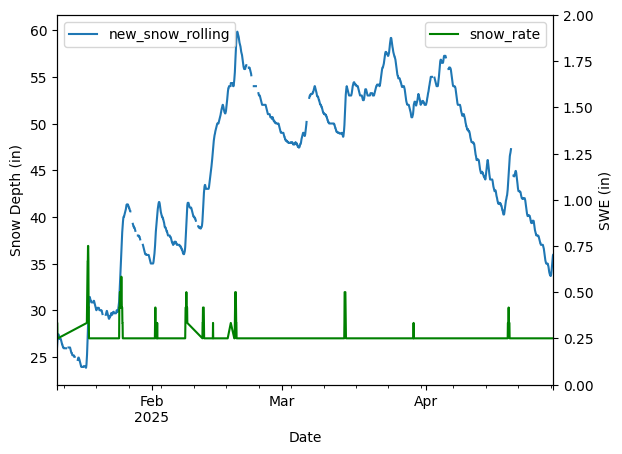

In [16]:
snotel_df = get_snotel_df(SiteName, years = 0.3)
window = 12
snotel_df['new_snow_rolling'] = snotel_df['snow_depth_in'].rolling(window=window).mean()
snotel_df['snow_rate'] = snotel_df['new_snow_rolling'].diff()
snotel_df['new_swe_in_rolling'] = snotel_df['swe_in'].rolling(window=window).mean()
snotel_df['swe_rate'] = snotel_df['new_swe_in_rolling'].diff()

fig, ax = plt.subplots()
ax_twin = ax.twinx()
snotel_df.plot(x = 'Date', y = 'new_snow_rolling', ax = ax)
# snotel_df.plot(x = 'Date', y = 'swe_in_rolling', ax = ax_twin, c = 'orange')
snow_event_min_filt = snotel_df['snow_rate'] > 0.2
snotel_df[snow_event_min_filt].plot(x = 'Date', y = 'snow_rate', ax = ax_twin, color = 'green', ylim = (0,2))
ax.set_ylabel('Snow Depth (in)')
ax_twin.set_ylabel('SWE (in)')

snow_events = snotel_df[snow_event_min_filt]
snow_events_totals = pd.DataFrame(columns = ['Date','snow_event_total', 'swe_event_total'])
last_time = snow_events['Date'].min()
final_time = snow_events['Date'].max()
current_snow_event_total = 0
current_swe_event_total = 0
for index, row in snow_events.iterrows():
    current_time = row['Date']
    if current_time - last_time < timedelta(hours = 12):
        current_snow_event_total += row['snow_rate']
        current_swe_event_total += row['swe_rate']
    elif (current_time - last_time > timedelta(hours = 4)) or (current_time == final_time):
        current_snow_event_total += last_snow_rate
        current_swe_event_total += last_swe_rate
        snow_events_totals.loc[len(snow_events_totals)] = [last_time,current_snow_event_total,current_swe_event_total]
        current_snow_event_total = 0
        current_swe_event_total = 0
    # print(row['Date'],current_snow_event_total)
    last_time = row['Date']
    last_snow_rate = row['snow_rate']
    last_swe_rate = row['swe_rate']
snow_events_totals['ratio'] = snow_events_totals['snow_event_total']/snow_events_totals['swe_event_total']
snow_events_totals

# Avalanche Count

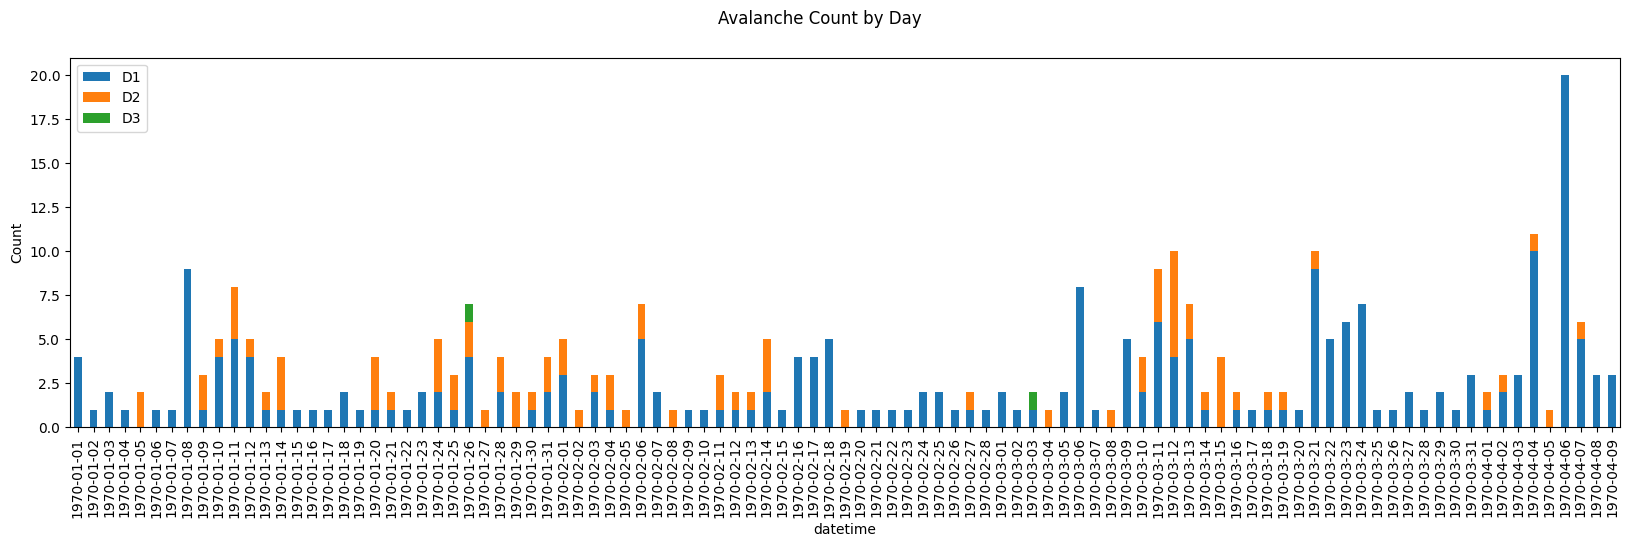

In [17]:
# def get_time(time_string):
month_dict = {'Jan':1,
              'Feb':2,
              'Mar':3,
              'Apr':4,
              'May':5,
              'Jun':6,
              'Jul':7,
              'Aug':8,
              'Sep':9,
              'Oct':10,
              'Nov':11,
              'Dec':12}
# time_string = ' Sun Feb 23 2025 12:00:00 GMT-0700 (Mountain Standard Time)'
def get_time(time_string):
    found = re.findall(r' (.+) (.+) (\d+) (\d\d\d\d) (\d+):(\d\d):(\d\d) GMT-(\d\d\d\d) \((.+)\)',time_string)[0]
    date_time = datetime(year = int(found[3]), month = month_dict[found[1]], day = int(found[2]))
    return date_time

av_df = pd.read_csv('avalanche-record-CAIC.csv')
av_df['datetime'] = av_df['Date'].apply(get_time)

av_count_df_d1 = av_df[av_df['sizeD'].isin([' D1',' D1.5'])].groupby('datetime')['Observation ID'].count().reset_index()
av_count_df_d2 = av_df[av_df['sizeD'].isin([' D2',' D2.5'])].groupby('datetime')['Observation ID'].count().reset_index()
av_count_df_d3 = av_df[av_df['sizeD'].isin([' D3'])].groupby('datetime')['Observation ID'].count().reset_index()

all_av_count_df = av_count_df_d1.merge(av_count_df_d2, on = 'datetime', how = 'outer').merge(av_count_df_d3, on = 'datetime', how = 'outer')
all_av_count_df.rename(columns = {'Observation ID_x':'D1','Observation ID_y':'D2','Observation ID':'D3'}, inplace = True)
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.suptitle('Avalanche Count by Day')
ax.set_ylabel('Count')
all_av_count_df.plot.bar(x = 'datetime', ax = ax, stacked = True)
date_format = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)



# Melt/Freeze
https://tc.copernicus.org/articles/17/211/2023/

In [18]:
ddf_s = 1 #Shortwave Radiattion component (greatest heat input from sun)
ddf_l = 1 #Longwave radiation component (blackbody radiation dumping heat away from snow primarily)
ddf_h = 1 #Sensible heat exchange describes the energy flux due to temperature differences between the air and the snow surface while air is permanently exchanged by wind turbulence.
ddf_e = 1 #Latent heat component - latent heat component DDFE is mainly dependent on the humidity gradient near the snow surface and on the wind speed. Additionally, altitude has an influence, as the air density decreases with altitude. 
ddf_p = 1 #Precipitation heat component

ddf_total = ddf_s + ddf_l + ddf_h + ddf_e + ddf_p

In [19]:
# https://www.starpath.com/blog_files/Table%20of%20the%20Declination%20of%20the%20Sun.pdf
sun_declination_df = pd.read_csv('sun_declination.csv')
declination_dict = {}
for index, row in sun_declination_df.iterrows():
    day = int(row['Day'])
    for month in range(1,13,1):
        for year in [datetime.now().year - 1, datetime.now().year, datetime.now().year + 1]:
            try:
                current_date = datetime(year = year, month = month, day = day).date()
                declination = float(row[month])*math.pi/180
                declination_dict[current_date] = declination
            except:
                pass

C:\Users\JonBanks\AppData\Local\Temp\ipykernel_16832\1645188235.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  declination = float(row[month])*math.pi/180


In [20]:
def calculate_ddf(current_datetime = datetime.now(),lat = 40.5,Albedo = None,c = 0):
    # #### Inputs
    # current_datetime = datetime.now()
    # lat = 40.5
    # Albedo = None
    # c = 0 #Fraction of cloud cover

    print('Shortwave Radiation')

    # Energy Balance

    #Snow albedo - 0.5 is typical 10 days after a snow event. Starts above 0.9 right after snow. This is the reflectivity of the snow.
    if Albedo != None:
        Amax = 0.95
        day_list = list(np.arange(0,31,1))
        day_list_int = [int(day) for day in day_list]
        A_list = [Amax]
        Alast = A_list[0]
        for day in day_list[1:]:
            An = 0.35 - (0.35-Amax)*(math.exp(-(0.177+(math.log(((Amax - 0.35)/(Alast - 0.35))**2.16)))))**0.46
            A_list.append(An)
            Alast = An

        Albedo_dict = {}
        for i, day in enumerate(day_list_int):
            Albedo_dict[day] = A_list[i]
        days_after_snow = 10
        Albedo = Albedo_dict[days_after_snow]

    G_s = 1361 #W/m^2 GS is the solar constant (W m−2),
    J = current_datetime.timetuple().tm_yday #Day of year
    d_r = math.sqrt(1/(1+0.034*math.cos(2*math.pi*J/365))) # Relative distance from sun
    phi = lat*math.pi/180 #Latitude in radians
    delta = declination_dict[datetime.now().date()] #Solar declination -  the declination ranges from 0 degree at the spring equinox, to + 23.45 degrees
    omega_s = math.acos(-math.tan(phi)*math.tan(delta)) #Sunrise hour angle
    S_0 =  G_s*(1/(d_r**2))*(1/math.pi)*(math.cos(phi)*math.cos(delta)*math.cos(omega_s) + omega_s*math.sin(phi)*math.sin(delta)) # Daily potential extraterrestrial solar ratiation without an atmosphere

    N = (sunset-sunrise).total_seconds()/3600 #Total possible hours of sunlight
    n = (1-c)*N #Actual hours of sunlight

    # K_t = 0.25 + 0.5*(n/N) #Clearness index (simple)
    z = 2000 #Altitude in meters?
    z_km = z/1000
    K_t = (0.1755 + 0.0136 * z_km) + (0.5414 + 0.0117*z_km)*(n/N) #Clearness index by altitude (Liu et al. (2019))
    K_t0 = (0.1755 + 0.0136 * 0) + (0.5414 + 0.0117*0)*(n/N) #Clearness index at 0m altitude
    K_z = K_t/K_t0
    S_i = K_t * S_0 #Incident solar radiation (W/m^2)
    q_s = (1-Albedo)*S_i
    print('  Day of Year:',J)
    print('  Relative Distance from Sun:',d_r)
    print('  Latitude:',phi,'rad')
    print('  Solar Declination:',delta,'rad')
    print('  Sunrise Hour Angle:', omega_s,'rad')
    print('  Mean daily potential extraterrestrial solar radiation:',S_0,'W/m^2')
    print('  Clearness index:',K_t)
    print('Shortwave Energy Flux:',q_s, "W/m^2")
    print()

    print('Longwave Radiation')
    T_c_snow = 0
    print('  Snow Temperature:',T_c_snow,'C')
    epsilon_snow = 0.982140944 #Emissivity of emitting body Fresh Snow:0.99, Old Snow:0.97
    print('  Emissivity of Snow:',epsilon_snow)
    sigma = 5.67e-8 #Stefan-Bolzmann constan W/(m^2*K^4)

    T_snow = T_c_snow + 273.15 #Temperature in Kelvin
    q_l_out = epsilon_snow * sigma * T_snow**4
    print('  Longwave Out:',q_l_out, 'W/m^2')
    print()
    T_c_air = 5
    print('  Air Temperature:',T_c_air)
    T_air = T_c_air + 273.15 #Temperature in Kelvin
    epsilon_air_clear = (9.2e-6)*T_air**2 #Clear Sky Emissivity of air. Varies from 0.6 to 0.8 depending on air temperature and humidity for clear skys. Overcast is close to 1.0.
    print('  Emissivity of Clear Air:',epsilon_air_clear)
    epsilon_air = (1-0.84*c)*epsilon_air_clear + 0.84*c
    print('  Cloud Cover:',c)
    print('  Emissivity of Air:',epsilon_air)
    q_l_in = epsilon_air * sigma * T_air**4
    q_l = q_l_in - q_l_out
    print('  Longwave In:',q_l_in, 'W/m^2')
    print('Total Longwave Energy Flux:',q_l, 'W/m^2')
    print()

    print('Sensible heat exchange')
    M_d = 0.02897#Molar Mass of air kg/mol
    R = 8.31446 #Universal Gas Constant (J/(mol*K))
    e = 0.622 #Ratio of molar weights of water and dry air
    p_0 = 101.325e3 #Atmospheric pressure at sea level (Pa)
    g = 9.8 #Gravitational acceeration (m/s^2)

    p = p_0*math.exp(((-g*M_d)/(R*T_air))*z) #Atmospheric pressure at altitude
    print('  Atmospheric Pressure:',p, 'Pa')
    relative_humidity = 0.3
    A = 17.2694
    B = 237.3
    C = 610.78
    p_s = C * math.exp(A*T_c_air/(B+T_c_air))#Saturation vapour pressure
    p_v = relative_humidity * p_s #Vapor Pressure (Pa)
    rho_a = M_d*(p - (1-e)*p_v)/(R*T_air)#Air Density (kg/m^3)
    print('  Air Density:',rho_a,'kg/m^3')
    k = 0.41 #(Karman constant)
    z_u = 1 # height of wind observation above snow surface (m)
    z_m = 0.001 #Momentum roughness parameter (m)
    z_T = 1 # Height of temperature observation above snow surface (m)
    z_h = 0.0002 #Heat roughness parameter (m)
    c_p = 1006 #Specific isobaric heat capacity of air (J/(kg*C))
    C_h = (k**2)/(math.log(z_u/z_m)*math.log(z_T/z_h)) #exchange coefficient CH
    u = 1 # Mean wind speed (m/s)
    q_h = rho_a*c_p*C_h*u*(T_air - T_snow)
    print('Sensible Heat Flux:',q_h,'W/m^2')
    print()

    print('Latent energy of condensation or vaporisation')
    lambda_v = 2.501e6 #Latent heat of vaporisation of water at 0C (J/kg)
    C_e = C_h#Exchange coefficient for latent heat
    spec_hum_a = (e/p)*p_v
    relative_humidity_s = 1
    p_vs = relative_humidity_s * p_s #Vapor Pressure (Pa) at the snow surface
    spec_hum_s = (e/p)*p_vs
    print(' Relative Humidity of Air:',relative_humidity)
    print(' Relative Humidity at Snow:',relative_humidity_s)
    q_e = rho_a*lambda_v*C_e*u*(spec_hum_a-spec_hum_s)
    print('Latent Energy of Condensation or Vaporization:',q_e,'W/m^2')
    print()

    print('Precipitation Heat')
    c_w = 4.2e3 # Specific heat capacity of water kJ/(kg*C)
    P = 50 # Daily rainfall depth (kg/(m^2*d)
    P_s = 50/(24*3600) # Daily rainfall depth (kg/(m^2*s)
    T_c_air = 15
    q_p = c_w * P_s * T_c_air
    print('Precipitation Heat Flux:',q_p,'W/m^2')
    print()

    q_g = 0 #Assume heat conduction from ground is 0
    delta_q = 0 # Temperature deltas within the snowpack can absorb heat and it's difficult to predict, so assume isothermal snowpack at 0C

    q_m = q_s + q_l + q_h + q_e + q_g + q_p - delta_q
    print('Total Energy Flux:',q_m,'W/m^2')
    print()

    lambda_f = 333.55 # Latent heat of fusion of ice (kJ/kg)
    rho_w = 999.84 #Density of water at 0C (kg/m^3)
    delta_t = 86400 # Time period (1day = 86400s)
    # M = (q_m/(lambda_f*rho_w))* delta_t # Melt depth (mm) - you get mm because 1mm of water is 1kg
    # print('Melt Depth:',M, 'mm')
    T_DD = 1
    ddf_s = ((q_s/(lambda_f*rho_w))* delta_t)/T_DD
    ddf_l = ((q_l/(lambda_f*rho_w))* delta_t)/T_DD
    ddf_h = ((q_h/(lambda_f*rho_w))* delta_t)/T_DD
    ddf_e = ((q_e/(lambda_f*rho_w))* delta_t)/T_DD
    ddf_g = ((q_g/(lambda_f*rho_w))* delta_t)/T_DD
    ddf_p = ((q_p/(lambda_f*rho_w))* delta_t)/T_DD

    return ddf_s, ddf_l, ddf_h, ddf_e, ddf_g, ddf_p

calculate_ddf(current_datetime = datetime.now(),lat = 40.5,Albedo = None,c = 0)

Shortwave Radiation


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
g_water = 5*100*100
g_water


50000

{0: 0.95,
 1: 0.9030838708521792,
 2: 0.8601020191263302,
 3: 0.8207040649101933,
 4: 0.7845725327941416,
 5: 0.7514196111988346,
 6: 0.7209842449597291,
 7: 0.6930295255127723,
 8: 0.6673403469827113,
 9: 0.6437212999781908,
 10: 0.6219947780000252,
 11: 0.6019992741180233,
 12: 0.5835878480090313,
 13: 0.5666267456109475,
 14: 0.5509941555664393,
 15: 0.536579088334204,
 16: 0.5232803653597026,
 17: 0.511005707043261,
 18: 0.4996709094405639,
 19: 0.4891991006958659,
 20: 0.4795200691567221,
 21: 0.4705696559639381,
 22: 0.4622892056634463,
 23: 0.45462506905826733,
 24: 0.44752815311774896,
 25: 0.44095351329595645,
 26: 0.4348599840885825,
 27: 0.42920984408436497,
 28: 0.42396851214836145,
 29: 0.41910427171549774,
 30: 0.4145880204779846}

0.0 1.0
0.1 0.9390769999999999
0.2 0.8671880000000001
0.30000000000000004 0.784333
0.4 0.690512
0.5 0.585725
0.6000000000000001 0.4699719999999999
0.7000000000000001 0.343253
0.8 0.20556799999999992
0.9 0.056916999999999884


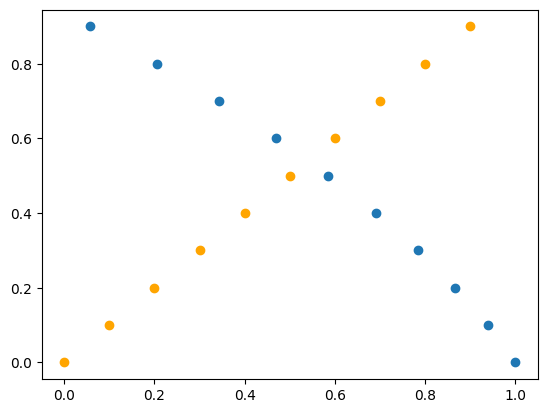

In [ ]:
sunshine_list = []
c_list = []
for sunshine in np.arange(0,1,0.1):
    sunshine_list.append(sunshine)
    c = 1-0.5544*(sunshine) - 0.5483*(sunshine)**2
    c_list.append(c)
    print(sunshine, c)

plt.scatter(x = c_list, y = sunshine_list)
plt.scatter(x = [n for n in np.arange(0,1,0.1)], y = [n for n in np.arange(0,1,0.1)], c = 'orange')

# Historic Snowpack

In [46]:
df = get_snotel_df('Niwot Ridge', years = 5.5)

Snotel URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/hourly/start_of_period/838:CO:SNTL%257Cid=%2522%2522%257Cname/2019-11-01,2025-05-01/WTEQ::value,SNWD::value,PREC::value,TOBS::value,WDIRV::value,WSPDV::value,WSPDX::value?fitToScreen=false
  (for humans): https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=838
Start retrieving SNOTEL data for University Camp, 838
     Received SNOTEL data
     Made dataframe
     Getting new snow totals
     rolling average


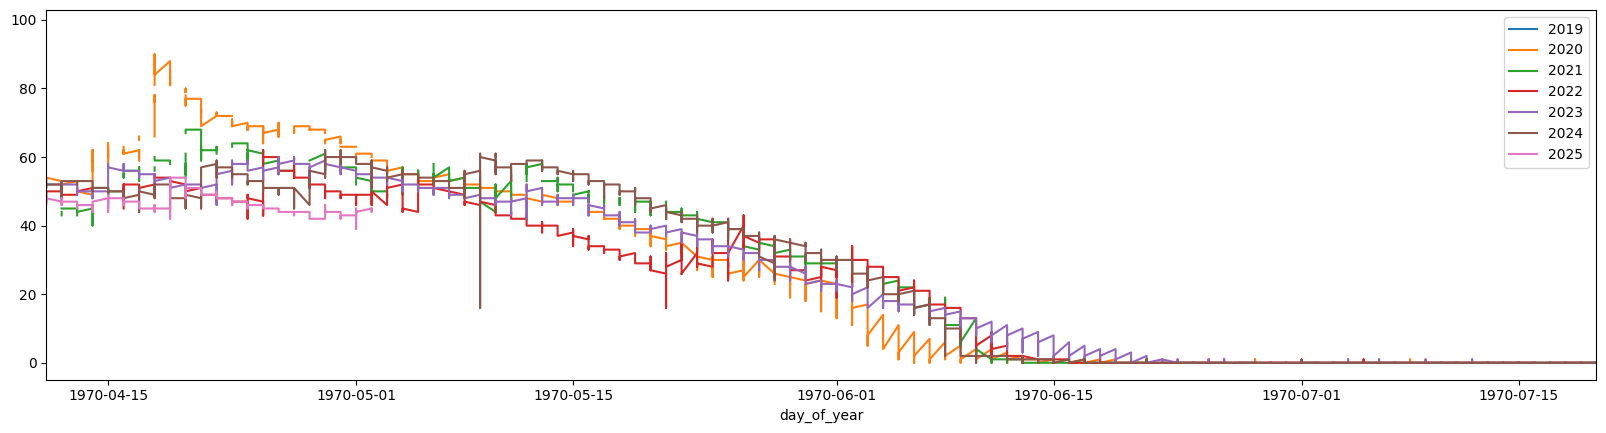

In [54]:
df['day_of_year'] = df['Date'].apply(lambda x: x.timetuple().tm_yday)
df['year'] = df['Date'].apply(lambda x: x.year)
fig, ax = plt.subplots()
fig.set_figwidth(20)



for year in df['year'].unique():
    df[df['year'] == year].plot(x = 'day_of_year', y = 'snow_depth_in', label = year, ax = ax, xlim = (100,200))

toll_date = datetime(2024,6,1)
toll_depth = df[df['Date'] == toll_date]['snow_depth_in'].mean()
ax.scatter( x = [toll_date], y = [toll_depth])


np.float64(26.0)